# Tabular Playground Series - Aug 2022

In this notebook, I created base model for TPS Aug 2022 and show **feature importances of models**. In below, some information about data is gave us. 

>This data represents the results of a large product testing study. For each **product_code** you are given a number of product **attributes** (fixed for the code) as well as a number of **measurement values** for each individual product, representing various lab testing methods. Each product is used in a simulated real-world environment experiment, and and absorbs a certain amount of fluid (**loading**) to see whether or not it fails.

>Your task is to use the data to predict individual product failures of new codes with their individual lab test results.

**Evaluation**: Submissions are evaluated on area under the ROC curve between the **predicted probability** and the observed target.

<a id="0"></a> <br>
# Table of Contents  
1. [Introduction to Tabular Playground Series - Aug 2022](#1)     
1. [A glance at the Data](#2) 
 1. [Create Train and Test Sets](#3) 
1. [EDA](#4)
1. [Missing Values](#4)
1. [Preprocess](#5)
1. [Basic Modelling](#10)
    1. [Logistic Regression](#11)
    1. [Feature Importance of Model](#12)
    1. [SVC - SVM Classifier](#31)
    1. [Random Forest](#13)
    1. [XGBoost](#20)
    1. [CatBoost Classifier](#32)
    1. [LightGBM](#33)
1. [Final Model](#25)
1. [Submission](#30)

<a id="1"></a> <br>
# 1. A glance at the Data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import seaborn as sns

# Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GroupKFold

# Metrics
from sklearn.metrics import roc_auc_score

# Model
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from colorama import Fore, Back, Style

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tabular-playground-series-aug-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-aug-2022/train.csv
/kaggle/input/tabular-playground-series-aug-2022/test.csv


In [2]:
df_train_full = pd.read_csv("/kaggle/input/tabular-playground-series-aug-2022/train.csv", index_col='id')
df_test = pd.read_csv("/kaggle/input/tabular-playground-series-aug-2022/test.csv", index_col='id')

df_train_full.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
id,,,,,,,,,,,,,,,,,,,,,
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


In [3]:
df_train_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26570 entries, 0 to 26569
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_code    26570 non-null  object 
 1   loading         26320 non-null  float64
 2   attribute_0     26570 non-null  object 
 3   attribute_1     26570 non-null  object 
 4   attribute_2     26570 non-null  int64  
 5   attribute_3     26570 non-null  int64  
 6   measurement_0   26570 non-null  int64  
 7   measurement_1   26570 non-null  int64  
 8   measurement_2   26570 non-null  int64  
 9   measurement_3   26189 non-null  float64
 10  measurement_4   26032 non-null  float64
 11  measurement_5   25894 non-null  float64
 12  measurement_6   25774 non-null  float64
 13  measurement_7   25633 non-null  float64
 14  measurement_8   25522 non-null  float64
 15  measurement_9   25343 non-null  float64
 16  measurement_10  25270 non-null  float64
 17  measurement_11  25102 non-null 

In [4]:
df_train_full.describe()

,loading,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
count,26320.000000,26570.000000,26570.000000,26570.000000,26570.000000,26570.000000,26189.000000,26032.000000,25894.000000,25774.000000,...,25343.000000,25270.000000,25102.000000,24969.000000,24796.000000,24696.000000,24561.000000,24460.000000,24286.000000,26570.000000
mean,127.826233,6.754046,7.240459,7.415883,8.232518,6.256568,17.791528,11.731988,17.127804,17.510759,...,11.430725,16.117711,19.172085,11.702464,15.652904,16.048444,14.995554,16.460727,701.269059,0.212608
std,39.030020,1.471852,1.456493,4.116690,4.199401,3.309109,1.001200,0.996085,0.996414,0.995980,...,0.999137,1.405978,1.520785,1.488838,1.155247,1.491923,1.549226,1.708935,123.304161,0.409160
min,33.160000,5.000000,5.000000,0.000000,0.000000,0.000000,13.968000,8.008000,12.073000,12.715000,...,7.537000,9.323000,12.461000,5.167000,10.890000,9.140000,9.104000,9.701000,196.787000,0.000000
25%,99.987500,6.000000,6.000000,4.000000,5.000000,4.000000,17.117000,11.051000,16.443000,16.839000,...,10.757000,15.209000,18.170000,10.703000,14.890000,15.057000,13.957000,15.268000,618.961500,0.000000
50%,122.390000,6.000000,8.000000,7.000000,8.000000,6.000000,17.787000,11.733000,17.132000,17.516000,...,11.430000,16.127000,19.211500,11.717000,15.628500,16.040000,14.969000,16.436000,701.024500,0.000000
75%,149.152500,8.000000,8.000000,10.000000,11.000000,8.000000,18.469000,12.410000,17.805000,18.178000,...,12.102000,17.025000,20.207000,12.709000,16.374000,17.082000,16.018000,17.628000,784.090250,0.000000
max,385.860000,9.000000,9.000000,29.000000,29.000000,24.000000,21.499000,16.484000,21.425000,21.543000,...,15.412000,22.479000,25.640000,17.663000,22.713000,22.303000,21.626000,24.094000,1312.794000,1.000000


### Ratio of the Failure on Train Set

0    20921
1     5649
Name: failure, dtype: int64


Text(0.5, 1.0, 'Failure Rate of Products on Training Set')

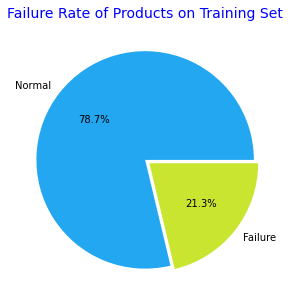

In [5]:
colors = ["#22a7f0","#c9e52f"]
labels = ['Normal', 'Failure']
explode = [0,0.05]

print(df_train_full.failure.value_counts())
           
plt.figure(figsize = (5,5))
plt.pie(df_train_full.failure.value_counts(),explode=explode, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title("Failure Rate of Products on Training Set", color = 'blue',fontsize = 14)

### Ratio of Nan Values
There is a lot of missing value. We will deal with them later.

In [6]:
cm = sns.light_palette("yellow", as_cmap=True)
pd.DataFrame({"NaN Count": df_train_full.isna().sum(),
              "NaN Ratio": df_train_full.isna().sum()/len(df_train_full)}).sort_values(by="NaN Count",
                                                                 ascending=False).style.background_gradient(cmap=cm)

,NaN Count,NaN Ratio
measurement_17,2284,0.085962
measurement_16,2110,0.079413
measurement_15,2009,0.075612
measurement_14,1874,0.070531
measurement_13,1774,0.066767
measurement_12,1601,0.060256
measurement_11,1468,0.055250
measurement_10,1300,0.048927
measurement_9,1227,0.046180
measurement_8,1048,0.039443


<a id="3"></a> <br>
## 1.A. Create Train and Test Sets

In [7]:
from sklearn.model_selection import train_test_split

random_state=42

y = df_train_full["failure"]  # save target
# df_train_full.drop(['failure'], axis=1, inplace=True) # drop target
df_train = df_train_full.drop(['failure'], axis=1)

test_size = 0.2
x_train, x_val, y_train, y_val = train_test_split(df_train, y , test_size = test_size, random_state=random_state)

In [8]:
print("x_train.shape: ",x_train.shape)
print("y_train.shape: ",y_train.shape)
print("x_val.shape: ",x_val.shape)
print("y_val.shape: ",y_val.shape)

x_train.shape:  (21256, 24)
y_train.shape:  (21256,)
x_val.shape:  (5314, 24)
y_val.shape:  (5314,)


In [9]:
df_train.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
id,,,,,,,,,,,,,,,,,,,,,
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,...,20.155,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,...,17.889,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,...,18.288,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,...,19.060,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,...,18.093,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885


**What's the ratio of failure numbers, after splitting data?**

In [10]:
x_train.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
id,,,,,,,,,,,,,,,,,,,,,
4031,A,125.77,material_7,material_8,9,5,13,1,3,16.957,...,21.896,NaN,14.837,17.120,13.848,16.205,14.036,12.391,15.069,879.008
2375,A,108.12,material_7,material_8,9,5,14,8,7,18.219,...,NaN,11.097,16.114,19.780,11.668,14.948,18.790,13.674,17.019,760.411
13904,C,190.34,material_7,material_8,5,8,16,11,10,17.512,...,18.780,10.582,15.999,18.201,10.160,16.337,16.701,15.145,16.283,675.360
18772,D,132.96,material_7,material_5,6,6,8,8,5,18.077,...,20.289,11.254,19.852,18.620,12.750,15.698,17.998,NaN,17.994,966.597
3884,A,108.12,material_7,material_8,9,5,11,5,4,18.878,...,18.192,10.980,14.872,21.283,11.759,16.563,17.046,14.296,14.557,566.990


Failure Rate on Splitted Training Set
 0    16664
1     4592
Name: failure, dtype: int64


Text(0.5, 1.0, 'Failure Rate on Training Set')

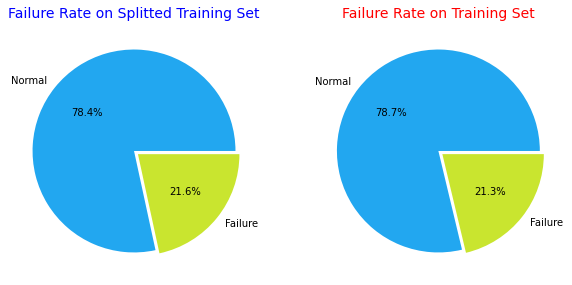

In [11]:
print("Failure Rate on Splitted Training Set\n",y_train.value_counts())
           
plt.figure(figsize = (10,5))

plt.subplot(1,2,1)
plt.pie(y_train.value_counts(),explode=explode, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title("Failure Rate on Splitted Training Set", color = 'blue',fontsize = 14)

plt.subplot(1,2,2)
plt.pie(df_train_full.failure.value_counts(),explode=explode, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title("Failure Rate on Training Set", color = 'Red',fontsize = 14)

<a id="3"></a> <br>
# 2. EDA

In [12]:
for column in x_train.columns:
    if x_train[column].dtypes == "object":
        print("\n",column)
        print(x_train[column].value_counts())

attributes = ["attribute_2", "attribute_3"]
print("\n",attributes[0])
print(x_train[attributes[0]].value_counts())
print("\n",attributes[1])
print(x_train[attributes[1]].value_counts())

# categorical_columns = 

# cm = sns.light_palette("red", as_cmap=True)
# pd.DataFrame({"NaN Count": df.isna().sum(),
#               "NaN Ratio": df.isna().sum()/len(df)}).sort_values(by="NaN Count",
#                                                                  ascending=False).style.background_gradient(cmap=cm)


 product_code
C    4615
E    4251
B    4175
D    4144
A    4071
Name: product_code, dtype: int64

 attribute_0
material_7    17081
material_5     4175
Name: attribute_0, dtype: int64

 attribute_1
material_8    8686
material_5    8319
material_6    4251
Name: attribute_1, dtype: int64

 attribute_2
6    8395
5    4615
8    4175
9    4071
Name: attribute_2, dtype: int64

 attribute_3
8    8790
9    4251
6    4144
5    4071
Name: attribute_3, dtype: int64


<a id="4"></a> <br>
## 2. Missing Values

In [13]:
x_train.isnull().sum()

product_code         0
loading            207
attribute_0          0
attribute_1          0
attribute_2          0
attribute_3          0
measurement_0        0
measurement_1        0
measurement_2        0
measurement_3      293
measurement_4      439
measurement_5      539
measurement_6      627
measurement_7      738
measurement_8      852
measurement_9      972
measurement_10    1042
measurement_11    1153
measurement_12    1315
measurement_13    1401
measurement_14    1496
measurement_15    1623
measurement_16    1699
measurement_17    1837
dtype: int64

<div class="alert alert-block alert-warning">
<b>Remember:</b> Null Values can be a sign of failure.
</div>

In [14]:
cols_with_missing = [col for col in df_train.columns if df_train[col].isnull().any()]
cols_with_missing

['loading',
 'measurement_3',
 'measurement_4',
 'measurement_5',
 'measurement_6',
 'measurement_7',
 'measurement_8',
 'measurement_9',
 'measurement_10',
 'measurement_11',
 'measurement_12',
 'measurement_13',
 'measurement_14',
 'measurement_15',
 'measurement_16',
 'measurement_17']

In [15]:
# new columns for missing columns
new_columns = []
for col in cols_with_missing:
    new_columns.append(f"{col}_was_missing")

print(new_columns)

['loading_was_missing', 'measurement_3_was_missing', 'measurement_4_was_missing', 'measurement_5_was_missing', 'measurement_6_was_missing', 'measurement_7_was_missing', 'measurement_8_was_missing', 'measurement_9_was_missing', 'measurement_10_was_missing', 'measurement_11_was_missing', 'measurement_12_was_missing', 'measurement_13_was_missing', 'measurement_14_was_missing', 'measurement_15_was_missing', 'measurement_16_was_missing', 'measurement_17_was_missing']


In [16]:
numerical_cols = [c for c in x_train.columns if x_train[c].dtypes in ['int', 'float']]
print("Numerical Columns\n", numerical_cols)

categorical_cols = [c for c in x_train.columns if x_train[c].dtypes in ['object']]
print("\nCategorical Columns\n", categorical_cols)

Numerical Columns
 ['loading', 'attribute_2', 'attribute_3', 'measurement_0', 'measurement_1', 'measurement_2', 'measurement_3', 'measurement_4', 'measurement_5', 'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17']

Categorical Columns
 ['product_code', 'attribute_0', 'attribute_1']


In [17]:
numerical_cols += new_columns
print(numerical_cols)

['loading', 'attribute_2', 'attribute_3', 'measurement_0', 'measurement_1', 'measurement_2', 'measurement_3', 'measurement_4', 'measurement_5', 'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17', 'loading_was_missing', 'measurement_3_was_missing', 'measurement_4_was_missing', 'measurement_5_was_missing', 'measurement_6_was_missing', 'measurement_7_was_missing', 'measurement_8_was_missing', 'measurement_9_was_missing', 'measurement_10_was_missing', 'measurement_11_was_missing', 'measurement_12_was_missing', 'measurement_13_was_missing', 'measurement_14_was_missing', 'measurement_15_was_missing', 'measurement_16_was_missing', 'measurement_17_was_missing']


<a id="5"></a> <br>
# Preprocess

In [18]:
# Preprocessing for numerical data
# it was constant
numerical_transformer = Pipeline(steps=[('imputer',SimpleImputer(strategy='median')),
                                        ('std_scaler', StandardScaler())
                                       ]) 


# # Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer([
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
])

In [19]:
x_train.head(10)

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
id,,,,,,,,,,,,,,,,,,,,,
4031,A,125.77,material_7,material_8,9,5,13,1,3,16.957,...,21.896,NaN,14.837,17.120,13.848,16.205,14.036,12.391,15.069,879.008
2375,A,108.12,material_7,material_8,9,5,14,8,7,18.219,...,NaN,11.097,16.114,19.780,11.668,14.948,18.790,13.674,17.019,760.411
13904,C,190.34,material_7,material_8,5,8,16,11,10,17.512,...,18.780,10.582,15.999,18.201,10.160,16.337,16.701,15.145,16.283,675.360
18772,D,132.96,material_7,material_5,6,6,8,8,5,18.077,...,20.289,11.254,19.852,18.620,12.750,15.698,17.998,NaN,17.994,966.597
3884,A,108.12,material_7,material_8,9,5,11,5,4,18.878,...,18.192,10.980,14.872,21.283,11.759,16.563,17.046,14.296,14.557,566.990
18347,D,144.12,material_7,material_5,6,6,7,8,6,16.929,...,18.541,9.553,13.386,20.145,11.973,16.659,15.823,13.875,18.638,804.271
5610,B,171.30,material_5,material_5,8,8,6,9,6,15.724,...,18.470,10.543,15.388,18.421,10.796,14.399,16.273,12.998,17.569,660.654
21940,E,174.71,material_7,material_6,6,9,3,18,0,18.154,...,18.990,13.491,17.749,19.830,10.391,NaN,14.896,13.928,15.057,762.758
25511,E,189.11,material_7,material_6,6,9,5,8,8,17.781,...,18.195,12.326,16.642,21.269,12.471,15.330,15.751,15.165,18.934,706.423


### Apply Preprocess and put on Pd DataFrame

In [20]:
df_train[categorical_cols]

,product_code,attribute_0,attribute_1
id,,,
0,A,material_7,material_8
1,A,material_7,material_8
2,A,material_7,material_8
3,A,material_7,material_8
4,A,material_7,material_8
...,...,...,...
26565,E,material_7,material_6
26566,E,material_7,material_6
26567,E,material_7,material_6


### Apply Preprocess
When I use preprocess on kfold, preprocess can't deal with test data columns categories that training data doesn't contain. So, I make preprocess before everything.

In [21]:
def do_preprocess(df, preprocessor, train = False):
    for col in cols_with_missing:
        df[col + '_was_missing'] = df[col].isnull()
    
    if train==True:
        df = preprocessor.fit_transform(df)
    else:
        df = preprocessor.transform(df)
    
    print(df.shape)
    
    return df

In [22]:
# x_train = preprocessor.fit_transform(x_train)
# x_val = preprocessor.transform(x_val)

x_train = do_preprocess(x_train, preprocessor, train=True)
x_val = do_preprocess(x_val, preprocessor, train=False)

(21256, 47)
(5314, 47)


In [23]:
x_train.shape

(21256, 47)

In [24]:
x_train

array([[-0.05212651,  1.52948135, -1.53568998, ...,  0.        ,
         0.        ,  1.        ],
       [-0.50681701,  1.52948135, -1.53568998, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.61129361, -1.18993777,  0.52516861, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.31334813,  1.52948135, -1.53568998, ...,  0.        ,
         0.        ,  1.        ],
       [ 2.27903172, -1.18993777,  0.52516861, ...,  0.        ,
         0.        ,  1.        ],
       [-0.1840254 , -0.51008299,  1.21212148, ...,  0.        ,
         1.        ,  0.        ]])

In [25]:
x_train[0:2]

array([[-5.21265117e-02,  1.52948135e+00, -1.53568998e+00,
         1.35551322e+00, -1.72380914e+00, -9.86569452e-01,
        -8.51043508e-01, -1.36194673e+00, -6.94104184e-01,
        -7.80730248e-02,  7.71803105e-01,  2.90645802e+00,
        -1.58882181e-04, -9.35673193e-01, -1.39019656e+00,
         1.48430633e+00,  4.96488592e-01, -1.40120639e+00,
        -1.75551790e+00, -8.50359795e-01,  1.50881804e+00,
        -9.91675169e-02, -1.18224393e-01, -1.45218915e-01,
        -1.61298731e-01, -1.74339053e-01, -1.89653415e-01,
        -2.04344117e-01,  4.56818484e+00, -2.27042797e-01,
        -2.39488254e-01, -2.56796683e-01, -2.65634281e-01,
        -2.75151780e-01, -2.87518588e-01, -2.94744406e-01,
        -3.07567999e-01,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00],
       [-5.06817006e-01,  1.52948135e+00, -1.53568998e+00,
         1.59

## New Columns After Preprocessing

In [26]:
for c in preprocessor.named_transformers_['cat']['onehot'].categories_:
    print(c)

cat_one_hot_attribs = np.concatenate([c for c in preprocessor.named_transformers_['cat']['onehot'].categories_])
print("\nCategorical Columns:\n", cat_one_hot_attribs) 
print("\nNumerical Columns:\n", numerical_cols)

all_cols = np.concatenate((numerical_cols, cat_one_hot_attribs))
print("\nAll Columns:\n", all_cols)
print("\nAll Columns Shape:", all_cols.shape)

['A' 'B' 'C' 'D' 'E']
['material_5' 'material_7']
['material_5' 'material_6' 'material_8']

Categorical Columns:
 ['A' 'B' 'C' 'D' 'E' 'material_5' 'material_7' 'material_5' 'material_6'
 'material_8']

Numerical Columns:
 ['loading', 'attribute_2', 'attribute_3', 'measurement_0', 'measurement_1', 'measurement_2', 'measurement_3', 'measurement_4', 'measurement_5', 'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17', 'loading_was_missing', 'measurement_3_was_missing', 'measurement_4_was_missing', 'measurement_5_was_missing', 'measurement_6_was_missing', 'measurement_7_was_missing', 'measurement_8_was_missing', 'measurement_9_was_missing', 'measurement_10_was_missing', 'measurement_11_was_missing', 'measurement_12_was_missing', 'measurement_13_was_missing', 'measurement_14_was_missing', 'measurement_15_was_missing', 'measurement_16

In [27]:
df = pd.DataFrame(x_train, columns=all_cols)
df.head(10)

,loading,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,...,A,B,C,D,E,material_5,material_7,material_5,material_6,material_8
0,-0.052127,1.529481,-1.535690,1.355513,-1.723809,-0.986569,-0.851044,-1.361947,-0.694104,-0.078073,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,-0.506817,1.529481,-1.535690,1.598637,-0.060532,0.224899,0.418221,-0.527740,0.277098,1.352635,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,1.611294,-1.189938,0.525169,2.084883,0.652301,1.133500,-0.292849,0.351969,0.270009,-1.492488,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.133099,-0.510083,-0.848737,0.139897,-0.060532,-0.380835,0.275403,-0.329552,0.262920,1.376056,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
4,-0.506817,1.529481,-1.535690,0.869267,-0.773365,-0.683702,1.081014,-0.988829,-0.832847,0.007464,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
5,0.420597,-0.510083,-0.848737,-0.103227,-0.060532,-0.077968,-0.879205,2.179136,-0.106725,1.488068,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
6,1.120795,0.849627,0.525169,-0.346350,0.177079,-0.077968,-2.091141,-0.361910,1.084238,0.836358,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
7,1.208641,-0.510083,1.212121,-1.075720,2.315579,-1.895171,0.352847,0.106258,-0.613086,0.752858,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
8,1.579607,-0.510083,1.212121,-0.589473,-0.060532,0.527766,-0.022300,-1.022197,1.745547,-0.095384,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
9,-1.442732,-0.510083,-0.848737,-0.103227,0.652301,1.133500,-0.371298,0.500610,1.170320,0.100129,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


<a id="10"></a> <br>
# Basic Modelling

<a id="11"></a> <br>
# LogisticRegression

In [28]:
%%time

model = LogisticRegression()
model.fit(x_train, y_train)

# We validate the model
y_val_pred = model.predict_proba(x_val)[:,1]
score = roc_auc_score(y_val, y_val_pred)
print(f"auc = {score:.5f}")

auc = 0.58801
CPU times: user 397 ms, sys: 231 ms, total: 628 ms
Wall time: 163 ms


<a id="12"></a> <br>
# Feature Importance of Model

In [29]:
feature_importances = model.coef_.ravel() # ravel that makes the list to flattened array
print(feature_importances.shape)
print(feature_importances)

(47,)
[ 0.29309896  0.00260418 -0.01865938  0.00716481 -0.00668561  0.05471817
  0.0080535  -0.03917941  0.01810977  0.02415464  0.02477674  0.01667664
 -0.01132773 -0.01585919 -0.02133473  0.01653588  0.01093535  0.0090498
  0.00312105  0.01372169  0.05672093 -0.02063273 -0.05144731  0.02014904
  0.04336289 -0.0140169   0.01143489 -0.00408293  0.00575449  0.00670278
  0.00319443  0.01385906 -0.00605591  0.00952491 -0.00554586 -0.00790789
  0.00597748  0.01642064 -0.02354647 -0.00144693 -0.0046771   0.01296385
 -0.02354647  0.02326047 -0.02822357  0.01296385  0.01497372]


In [30]:
feature_importance_list = sorted(zip(feature_importances, all_cols), reverse=True)
pd.DataFrame(feature_importance_list).head()

,0,1
0,0.293099,loading
1,0.056721,measurement_17
2,0.054718,measurement_2
3,0.043363,measurement_5_was_missing
4,0.024777,measurement_7


In [31]:
df_feature_importance = pd.DataFrame(np.array(feature_importances).reshape(1, len(feature_importances)), columns=all_cols)
df_feature_importance.head()

,loading,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,...,A,B,C,D,E,material_5,material_7,material_5,material_6,material_8
0,0.293099,0.002604,-0.018659,0.007165,-0.006686,0.054718,0.008053,-0.039179,0.01811,0.024155,...,0.016421,-0.023546,-0.001447,-0.004677,0.012964,-0.023546,0.02326,-0.028224,0.012964,0.014974


In [32]:
# example to show whats going on feature_importance_list
feature_importances_list = []
feature_importances_list.append(feature_importances)
feature_importances_list.append(feature_importances)
print(np.array(feature_importances_list).shape)
print(np.array(feature_importances_list).T.shape)

(2, 47)
(47, 2)


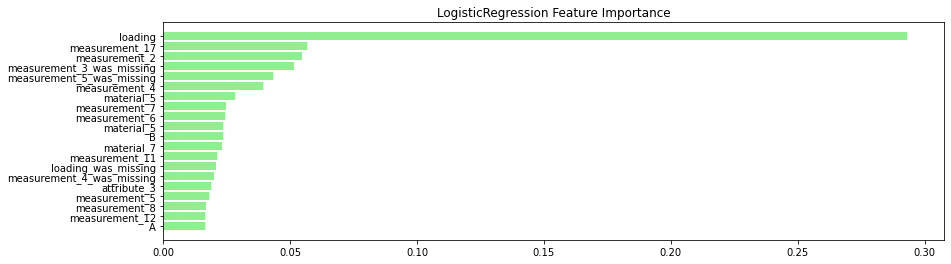

In [33]:
# Show feature importances
# code source : https://www.kaggle.com/code/ambrosm/tpsaug22-eda-which-makes-sense
def plot_model_feature_importance(feature_importance_list, features, title_name='Model', number_of_features=10):
    """
    features_importance_list: array of features importance
    features: a array that contain columns or features names
    title_name = title of graph
    number_of_features : how many numbers of features to show on the graph
    """
    importance_df = pd.DataFrame(np.array(feature_importance_list).T, index=features)
    importance_df['mean'] = importance_df.mean(axis=1).abs()
    importance_df['feature'] = features
    importance_df = importance_df.sort_values('mean', ascending=False).reset_index().head(number_of_features)
    plt.figure(figsize=(14, 4))
    plt.barh(importance_df.index, importance_df['mean'], color='lightgreen')
    plt.gca().invert_yaxis()
    plt.yticks(ticks=importance_df.index, labels=importance_df['feature'])
    plt.title(title_name + " Feature Importance")
    plt.show()
    
    return importance_df # to show the dataframe

importance_df = plot_model_feature_importance(feature_importances, all_cols, title_name="LogisticRegression", number_of_features=20)

In [34]:
importance_df.head()

,index,0,mean,feature
0,loading,0.293099,0.293099,loading
1,measurement_17,0.056721,0.056721,measurement_17
2,measurement_2,0.054718,0.054718,measurement_2
3,measurement_3_was_missing,-0.051447,0.051447,measurement_3_was_missing
4,measurement_5_was_missing,0.043363,0.043363,measurement_5_was_missing


<a id="31"></a> <br>
# SVC - SVM Classifier

In [35]:
# from sklearn.inspection import permutation_importance

In [36]:
# %%time
# model = SVC(probability=True)
# model.fit(x_train, y_train)

In [37]:
# %%time
# # We validate the model
# y_val_pred = model.predict_proba(x_val)[:,1]
# score = roc_auc_score(y_val, y_val_pred)
# print(f"auc = {score:.5f}")

In [38]:
# %%time
# # feature_importances = model.coef_.ravel() # ravel that makes the list to flattened array

# perm_importance = permutation_importance(model, x_train, y_train)
# # importance_df = plot_model_feature_importance(feature_importances, all_cols, title_name="SVC", number_of_features=20)

<a id="13"></a> <br>
# RandomForestClassifier

In [39]:
%%time
random_forest = RandomForestClassifier(n_estimators=100, random_state=0)

random_forest.fit(x_train, y_train)

CPU times: user 9.42 s, sys: 42.3 ms, total: 9.46 s
Wall time: 9.48 s


RandomForestClassifier(random_state=0)

In [40]:
# We validate the model
y_val_pred = random_forest.predict_proba(x_val)[:,1]
score = roc_auc_score(y_val, y_val_pred)
print(f"auc = {score:.5f}")

auc = 0.55575


In [41]:
# feature importance for RandomForestClassifier
feature_importances = random_forest.feature_importances_
feature_importances

array([0.0663639 , 0.00857186, 0.00815086, 0.03387101, 0.03426656,
       0.03261221, 0.05036885, 0.04998795, 0.05049431, 0.04881541,
       0.04874038, 0.04941006, 0.04968118, 0.04834884, 0.04870724,
       0.04921982, 0.049205  , 0.04899003, 0.04748329, 0.0487998 ,
       0.04832425, 0.0009444 , 0.00109169, 0.00225447, 0.00259548,
       0.00216931, 0.00272223, 0.00285234, 0.00302511, 0.00326151,
       0.00336941, 0.00369206, 0.00358995, 0.003855  , 0.00388524,
       0.00373837, 0.00397392, 0.00285275, 0.00274582, 0.00351036,
       0.00374673, 0.00323803, 0.0026712 , 0.00266094, 0.0038962 ,
       0.00323731, 0.00400741])

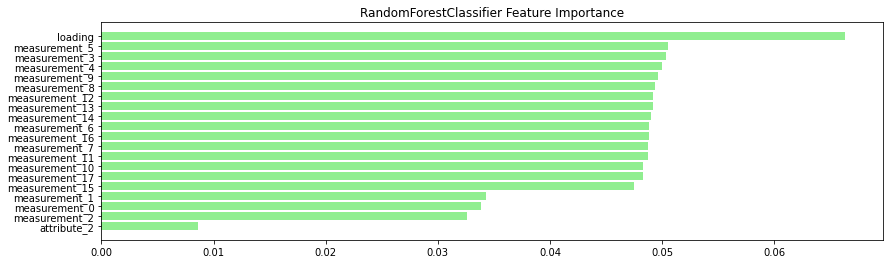

In [42]:
importance_df = plot_model_feature_importance(feature_importances, all_cols, title_name="RandomForestClassifier", number_of_features=20)

<a id="20"></a> <br>
# XGBoost

In [43]:
# !pip install --upgrade xgboost
from xgboost import XGBClassifier

In [44]:
%%time
model = XGBClassifier()

model.fit(x_train, y_train)

CPU times: user 16.5 s, sys: 49.6 ms, total: 16.5 s
Wall time: 4.17 s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [45]:
# We validate the model
y_val_pred = model.predict_proba(x_val)[:,1]
score = roc_auc_score(y_val, y_val_pred)
print(f"auc = {score:.5f}")

auc = 0.55216


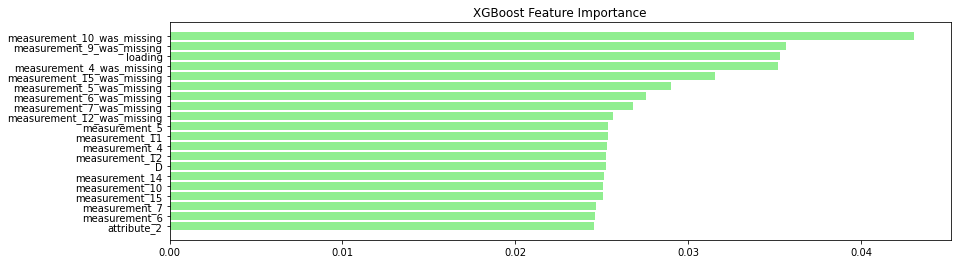

In [46]:
feature_importances = model.feature_importances_
importance_df = plot_model_feature_importance(feature_importances, all_cols, title_name="XGBoost", number_of_features=20)

<a id="32"></a> <br>
# CatBoost Classifier

In [47]:
model = CatBoostClassifier(iterations=10,verbose=5)
model.fit(x_train, y_train)

Learning rate set to 0.5
0:	learn: 0.5551668	total: 66.6ms	remaining: 599ms
5:	learn: 0.5077395	total: 110ms	remaining: 73.5ms
9:	learn: 0.5015050	total: 149ms	remaining: 0us


In [48]:
# We validate the model
y_val_pred = model.predict_proba(x_val)[:,1]
score = roc_auc_score(y_val, y_val_pred)
print(f"auc = {score:.5f}")

auc = 0.59041


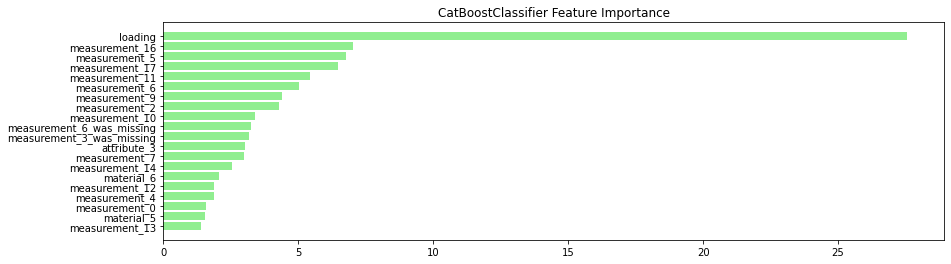

In [49]:
feature_importances = model.feature_importances_
importance_df = plot_model_feature_importance(feature_importances, all_cols, title_name="CatBoostClassifier", number_of_features=20)

<a id="33"></a> <br>
# LightGBM

In [50]:
model = LGBMClassifier()
model.fit(x_train, y_train)

LGBMClassifier()

In [51]:
# We validate the model
y_val_pred = model.predict_proba(x_val)[:,1]
score = roc_auc_score(y_val, y_val_pred)
print(f"auc = {score:.5f}")

auc = 0.57595


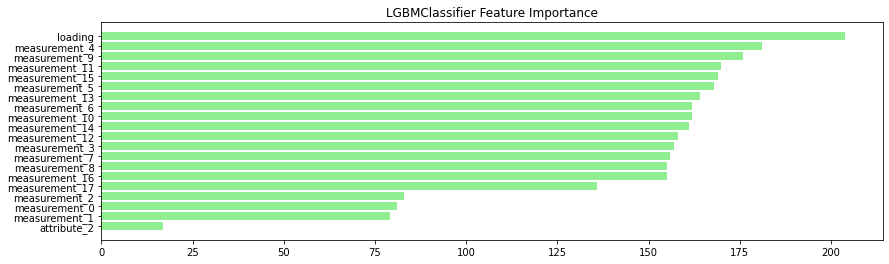

In [52]:
feature_importances = model.feature_importances_
importance_df = plot_model_feature_importance(feature_importances, all_cols, title_name="LGBMClassifier", number_of_features=20)

# Evaluate Models

In [53]:
# %%time
# model_list = [("SVC", SVC(probability=True)), 
#               ("LogisticRegression", LogisticRegression()),
#               ("XGBoost", XGBClassifier()),
#               ("RandomForestClassifier", RandomForestClassifier(n_estimators=100, random_state=0)),
#               ("CatBoostClassifier", CatBoostClassifier(iterations=10,verbose=5)),
#               ("LGBMClassifier", LGBMClassifier())]


# models_auc_scores = []

# model_names = []

# for i in range(len(model_list)):
#     model_names.append(model_list[i][0])


# for name, model in model_list:
#     print(f"-----{name}-----")
#     model.fit(x_train, y_train)
    
#     #Evaluating on Validation Set
#     y_val_pred = model.predict_proba(x_val)[:,1]
#     score = roc_auc_score(y_val, y_val_pred)
#     print(f"auc = {score:.5f}")
    
#     models_auc_scores.append(score)
    
#     #Feature Importances
#     if name == "LogisticRegression":
#         feature_importances = model.coef_.ravel()
#     else:   
#         feature_importances = model.feature_importances_
        
#     importance_df = plot_model_feature_importance(feature_importances, all_cols, number_of_features=20)

# # Models Auc Score Comparison
# df_models_auc_score = pd.DataFrame(np.array(models_auc_scores).T, index=model_names)
# df_models_auc_score = df_models_auc_score.sort_values(0, ascending=False).reset_index()

# plt.figure(figsize=(8, 2))
# plt.barh(df_models_auc_score["index"], df_models_auc_score[0], color='purple')
# plt.gca().invert_yaxis()
# plt.title("Models Auc Score Comparison")
# plt.show()

# Train on All Training Data

In [54]:
x_train_all = do_preprocess(df_train, preprocessor, train=True)

(26570, 47)


In [55]:
# model = LogisticRegression()
# model = XGBClassifier()
# model = CatBoostClassifier(iterations=10,verbose=5)
# model = LGBMClassifier()

In [56]:
model.fit(x_train_all, y)

LGBMClassifier()

<a id="30"></a> <br>
# Submission

In [57]:
x_test = do_preprocess(df_test, preprocessor, train=False)
# x_test = preprocessor.transform(df_test)

(20775, 47)


In [58]:
test_pred = model.predict_proba(x_test)[:,1]
test_pred

array([0.20040493, 0.2038508 , 0.10737566, ..., 0.13649042, 0.19488358,
       0.10921552])

In [59]:
submission = pd.DataFrame({'id': df_test.index,
                           'failure': test_pred})
submission.to_csv('submission.csv', index=False)
submission

,id,failure
0,26570,0.200405
1,26571,0.203851
2,26572,0.107376
3,26573,0.147961
4,26574,0.201598
...,...,...
20770,47340,0.227544
20771,47341,0.125890
20772,47342,0.136490
20773,47343,0.194884
